# ** CPSC 8810 Deep Learning - HW1-2 **
---

## Introduction
_**Note:** This assignment makes use of the CIFAR-10 dataset which can be find from this link 
, [CIFAR-10 Dataset](https://www.cs.toronto.edu/~kriz/cifar.html)._

The main objective of this assignments:
* Train 2 distinct neural network with same amount of parameters until convergence
* Compare the training process of two different models
* Visualize ground truth and predictions from models

In [14]:
import tensorflow as tf
import cv2
from tensorflow.examples.tutorials.mnist import input_data
from sklearn.decomposition import PCA

tf.__version__
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

## MNIST Dataset Preparation and Visualization

In [15]:
data = input_data.read_data_sets('data/MNIST/', one_hot=True);

train_num = data.train.num_examples;
valid_num = data.validation.num_examples;
test_num = data.test.num_examples;
img_flatten = 784
img_size = 28
num_classes = 10
print("Training Dataset Size:",train_num)
print("Validation Dataset Size:",valid_num)
print("Testing Dataset Size:",test_num)

Extracting data/MNIST/train-images-idx3-ubyte.gz
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz
Training Dataset Size: 55000
Validation Dataset Size: 5000
Testing Dataset Size: 10000


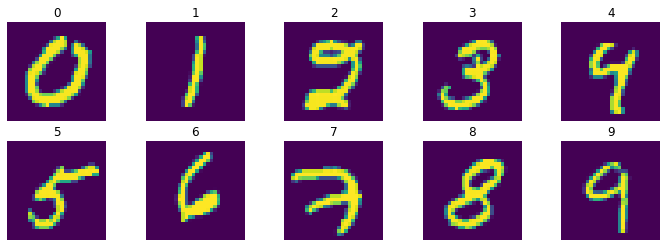

In [16]:
fig, axs = plt.subplots(2,5)
fig.set_size_inches(12,4)
for i in range(10):
    idx = np.where(np.argmax(data.train.labels,1)==i)[0][0]
    axs[int(i/5),i%5].imshow(data.train.images[idx].reshape(28,28))
    axs[int(i/5),i%5].set_title(str(i))
    axs[int(i/5),i%5].axis('off')

### CIFAR-10 Data Distribution Before Augmentation

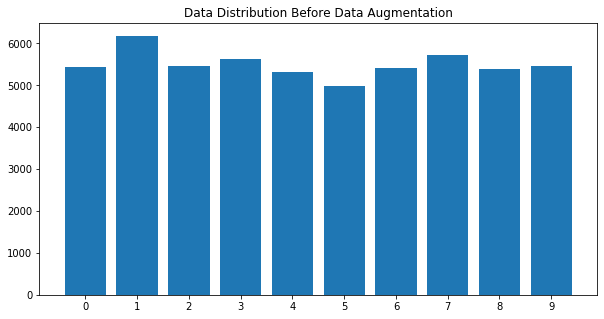

In [17]:
bar_fig = plt.figure(figsize=[10,5])
unique, counts = np.unique(np.argmax(data.train.labels,1), return_counts=True)
plt.bar(unique,counts)
plt.title("Data Distribution Before Data Augmentation")
plt.xticks(unique,np.arange(10));

## Model 1 Architecture

In [18]:
tf.reset_default_graph()
x = tf.placeholder(tf.float32, shape=[None, img_flatten], name='x')
input_x = tf.reshape(x,[-1,img_size,img_size,1])
y = tf.placeholder(tf.float32, shape=[None, num_classes], name='y')
y_cls = tf.argmax(y,dimension=1)

m1_conv1 = tf.layers.conv2d(inputs=input_x,filters=16,kernel_size=5,padding="same",activation=tf.nn.relu,name='layer_conv1');
m1_pool1 = tf.layers.max_pooling2d(inputs=m1_conv1,pool_size=2,strides=2);
m1_conv2 = tf.layers.conv2d(inputs=m1_pool1,filters=36,kernel_size=5,padding="same",activation=tf.nn.relu,name='layer_conv2');
m1_pool2 = tf.layers.max_pooling2d(inputs=m1_conv2,pool_size=2,strides=2);
m1_flat1 = tf.layers.flatten(m1_pool2);
m1_fc1 = tf.layers.dense(inputs=m1_flat1,units=128,activation=tf.nn.relu, name='layer_fc1');
m1_logits = tf.layers.dense(inputs=m1_fc1,units=num_classes,activation=None, name='layer_fc_out');

# Cross Entropy Loss
m1_cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=y,logits=m1_logits);
m1_loss = tf.reduce_mean(m1_cross_entropy);

# Accuracy
m1_softmax = tf.nn.softmax(logits=m1_logits);
m1_pred_op = tf.argmax(m1_softmax,dimension=1);
m1_acc_op = tf.reduce_mean(tf.cast(tf.equal(m1_pred_op, y_cls), tf.float32));

# Optimizer and Training Operation
m1_optimizer = tf.train.AdamOptimizer(learning_rate=0.005);
m1_train_op = m1_optimizer.minimize(m1_loss);

## Training Model 1 on MNIST Dataset

In [19]:
session = tf.Session()
session.run(tf.global_variables_initializer())
train_batch_size = 64

num_iteration = 200
test_loss_list1 = []
train_loss_list1 = []
test_acc_list1 = []
train_acc_list1 = []

for i in range(num_iteration):
    x_batch, y_true_batch = data.train.next_batch(train_batch_size)
    train_loss,train_acc,_ = session.run([m1_loss,m1_acc_op,m1_train_op], feed_dict={x: x_batch,y: y_true_batch})
    test_loss, test_acc = session.run([m1_loss,m1_acc_op],feed_dict={x:data.test.images,y:data.test.labels})
    test_loss_list1.append(test_loss)
    train_loss_list1.append(train_loss)
    test_acc_list1.append(test_acc)
    train_acc_list1.append(train_acc)
    if i % 20 == 0:
        # Calculate the accuracy on the training-set.
        msg = "Iteration: {0:>6}, Training Loss: {1:>1.6}, Training Accuracy: {2:>6.1%}"
        print(msg.format(i + 1, train_loss, train_acc))

Iteration:      1, Training Loss: 2.2958, Training Accuracy:  17.2%
Iteration:     21, Training Loss: 0.417451, Training Accuracy:  87.5%
Iteration:     41, Training Loss: 0.237961, Training Accuracy:  89.1%
Iteration:     61, Training Loss: 0.0583298, Training Accuracy:  98.4%
Iteration:     81, Training Loss: 0.143592, Training Accuracy:  93.8%
Iteration:    101, Training Loss: 0.199577, Training Accuracy:  93.8%
Iteration:    121, Training Loss: 0.072717, Training Accuracy:  98.4%
Iteration:    141, Training Loss: 0.208036, Training Accuracy:  95.3%
Iteration:    161, Training Loss: 0.0970865, Training Accuracy:  98.4%
Iteration:    181, Training Loss: 0.343193, Training Accuracy:  90.6%


Text(0, 0.5, 'Accuracy')

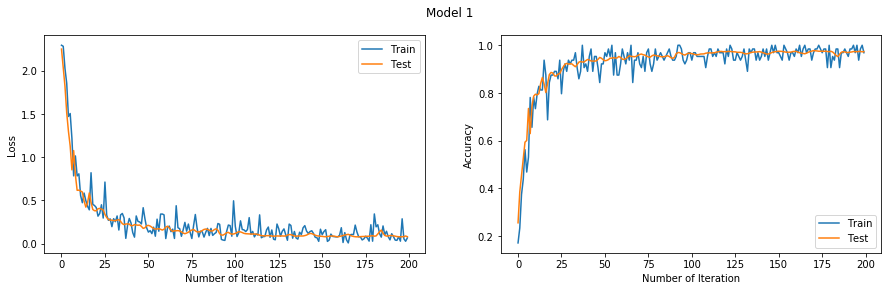

In [25]:
fig,axs = plt.subplots(1,2)
fig.set_figwidth(15)
fig.suptitle('Model 1')
axs[0].plot(np.arange(0,num_iteration),train_loss_list1)
axs[0].plot(np.arange(0,num_iteration),test_loss_list1)
axs[0].legend(['Train','Test'])
axs[0].set_xlabel('Number of Iteration')
axs[0].set_ylabel('Loss')
axs[1].plot(np.arange(0,num_iteration),train_acc_list1)
axs[1].plot(np.arange(0,num_iteration),test_acc_list1)
axs[1].legend(['Train','Test'])
axs[1].set_xlabel('Number of Iteration')
axs[1].set_ylabel('Accuracy')

## Model 2 Architecture

In [21]:
tf.reset_default_graph()
x = tf.placeholder(tf.float32, shape=[None, img_flatten], name='x')
input_x = tf.reshape(x,[-1,img_size,img_size,1])
y = tf.placeholder(tf.float32, shape=[None, num_classes], name='y')
y_cls = tf.argmax(y,dimension=1)

m1_conv1 = tf.layers.conv2d(inputs=input_x,filters=8,kernel_size=5,padding="same",activation=tf.nn.relu,name='layer_conv1');
m1_pool1 = tf.layers.max_pooling2d(inputs=m1_conv1,pool_size=2,strides=2);
m1_conv2 = tf.layers.conv2d(inputs=m1_pool1,filters=18,kernel_size=5,padding="same",activation=tf.nn.relu,name='layer_conv2');
m1_pool2 = tf.layers.max_pooling2d(inputs=m1_conv2,pool_size=2,strides=2);
m1_flat1 = tf.layers.flatten(m1_pool2);
m1_fc1 = tf.layers.dense(inputs=m1_flat1,units=164,activation=tf.nn.relu, name='layer_fc1');
m1_logits = tf.layers.dense(inputs=m1_fc1,units=num_classes,activation=None, name='layer_fc_out');

# Cross Entropy Loss
m1_cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=y,logits=m1_logits);
m1_loss = tf.reduce_mean(m1_cross_entropy);

# Accuracy
m1_softmax = tf.nn.softmax(logits=m1_logits);
m1_pred_op = tf.argmax(m1_softmax,dimension=1);
m1_acc_op = tf.reduce_mean(tf.cast(tf.equal(m1_pred_op, y_cls), tf.float32));

# Optimizer and Training Operation
m1_optimizer = tf.train.AdamOptimizer(learning_rate=0.005);
m1_train_op = m1_optimizer.minimize(m1_loss);

## Training Model 2 MNIST Dataset

In [22]:
session = tf.Session()
session.run(tf.global_variables_initializer())
train_batch_size = 64

num_iteration = 200
test_loss_list2 = []
train_loss_list2 = []
test_acc_list2 = []
train_acc_list2 = []

for i in range(num_iteration):
    x_batch, y_true_batch = data.train.next_batch(train_batch_size)
    train_loss,train_acc,_ = session.run([m1_loss,m1_acc_op,m1_train_op], feed_dict={x: x_batch,y: y_true_batch})
    test_loss, test_acc = session.run([m1_loss,m1_acc_op],feed_dict={x:data.test.images,y:data.test.labels})
    test_loss_list2.append(test_loss)
    train_loss_list2.append(train_loss)
    test_acc_list2.append(test_acc)
    train_acc_list2.append(train_acc)
    if i % 20 == 0:
        # Calculate the accuracy on the training-set.
        msg = "Iteration: {0:>6}, Training Loss: {1:>1.6}, Training Accuracy: {2:>6.1%}"
        print(msg.format(i + 1, train_loss, train_acc))

Iteration:      1, Training Loss: 2.27663, Training Accuracy:  10.9%
Iteration:     21, Training Loss: 0.469142, Training Accuracy:  82.8%
Iteration:     41, Training Loss: 0.18312, Training Accuracy:  95.3%
Iteration:     61, Training Loss: 0.132971, Training Accuracy:  95.3%
Iteration:     81, Training Loss: 0.170162, Training Accuracy:  92.2%
Iteration:    101, Training Loss: 0.133212, Training Accuracy:  93.8%
Iteration:    121, Training Loss: 0.109445, Training Accuracy:  95.3%
Iteration:    141, Training Loss: 0.244926, Training Accuracy:  90.6%
Iteration:    161, Training Loss: 0.115164, Training Accuracy:  95.3%
Iteration:    181, Training Loss: 0.0946103, Training Accuracy:  98.4%


Text(0, 0.5, 'Accuracy')

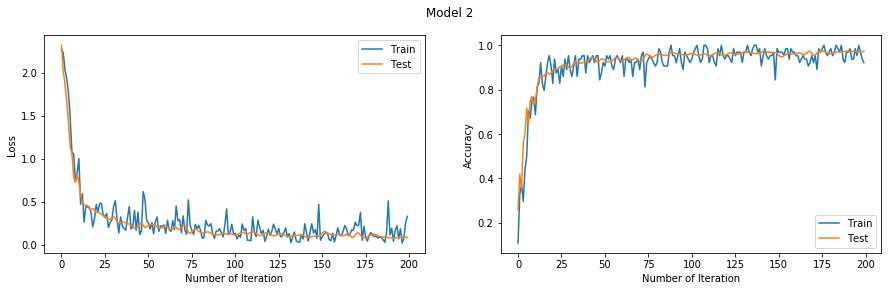

In [24]:
fig,axs = plt.subplots(1,2)
fig.set_figwidth(15)
fig.suptitle('Model 2')
axs[0].plot(np.arange(0,num_iteration),train_loss_list2)
axs[0].plot(np.arange(0,num_iteration),test_loss_list2)
axs[0].legend(['Train','Test'])
axs[0].set_xlabel('Number of Iteration')
axs[0].set_ylabel('Loss')
axs[1].plot(np.arange(0,num_iteration),train_acc_list2)
axs[1].plot(np.arange(0,num_iteration),test_acc_list2)
axs[1].legend(['Train','Test'])
axs[1].set_xlabel('Number of Iteration')
axs[1].set_ylabel('Accuracy')